In [1]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import sys

In [2]:
from parameters import *
#from variables import *
from initial import *
from advectionx import*
from advectiony import*
from advectionz import*
from dispersionx import *
from dispersiony import *
from dispersionz import *
from degree_conversion import *
from settling import *
from landed import *
from utils import inside_chimney, touch_dir
from matplotlib.ticker import FormatStrFormatter

In [3]:
car_out = './car_outfigs'
touch_dir(car_out)

In [4]:
lon_range = 1e-4
lat_range = 1e-4
height_limit = 3

lon1 = start_lon - lon_range
lon2 = start_lon + 2*lon_range
lat1 = start_lat - lat_range
lat2 = start_lat + lat_range

n_particles = 3000

In [5]:
lat1, start_lat, lat2

(15.141567, 15.141667, 15.141767)

(3000,)
[[  0.20000802  15.14166774 120.35000949]
 [  0.20000401  15.14167002 120.35002846]
 [  0.20000786  15.14166888 120.35004313]
 ...
 [  0.20000725  15.14167683 120.35002132]
 [  0.20000682  15.14166894 120.3500083 ]
 [  0.20000722  15.14167396 120.35000711]]


Text(0.5, 0.92, 'Particle Trajectory')

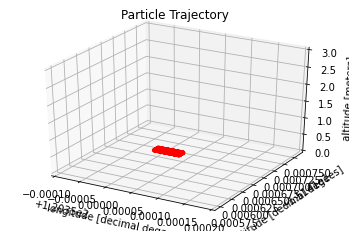

In [6]:
Rold = initial(1e-5,5e-5, source='car', n_particles=n_particles)

num_particles = len(Rold)
#particle #,  location of paritcles
Rnew = np.zeros((num_particles,3)) #lat,lon,alt
#Rold = np.zeros((num_particles,3)) #lat,lon,alt
R_step1 = np.zeros((num_particles,3)) #lat,lon,alt
R_step2 = np.zeros((num_particles,3)) #lat,lon,alt
R_step3 = np.zeros((num_particles,3)) #lat,lon,alt
R_step4 = np.zeros((num_particles,3)) #lat,lon,alt
Active = np.ones((num_particles)) #lat,lon,alt
print(Active.shape)

print(Rold)
fig = plt.figure(1,facecolor = 'white')
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('longitude [decimal degees]')
ax.set_ylabel('latitude [decimal degees]')
ax.set_zlabel('altitude [meters]')
ax.set_zlim(0,height_limit)
ax.set_ylim(lat1,lat2)
ax.set_xlim(lon1,lon2)
ax.scatter(Rold[:,2],Rold[:,1],Rold[:,0],c='r',s=10)
ax.set_title('Particle Trajectory')

In [7]:
j=3
ts = time.time()
for t in range(1,time_steps):
    
#     if t%10 == 0:
#         te = time.time()-ts
#         print("now at time step: {}, wall time elapsed: {:6.2f} secs.".format(t, te))
    
    t_index = int(float(t)/float(time_steps)*20.)
    t_time_1 = float(t)/float(time_steps)*20.
    t_time_2 = (float(t)+0.5)/float(time_steps)*20.
    t_time_3 = (float(t)+0.5)/float(time_steps)*20.
    t_time_4 = (float(t)+1.0)/float(time_steps)*20.    
    
    dx_lat, dx_lon = degree_to_dx(Rold)
    
    #RUNGA KUTTA 
    R_step1[:,:] = 0.0
    R_step2[:,:] = 0.0
    R_step3[:,:] = 0.0
    R_step4[:,:] = 0.0
    #dispersion
    dispz_temp = dispersionz(Active) * dt
    dispy_temp = dispersiony(Active) * dt / dx_lat
    dispx_temp = dispersionx(Active) * dt / dx_lon
    R_step1[:,0] += dispz_temp
    R_step2[:,0] += dispz_temp
    R_step3[:,0] += dispz_temp
    R_step4[:,0] += dispz_temp
    R_step1[:,1] += dispy_temp
    R_step2[:,1] += dispy_temp
    R_step3[:,1] += dispy_temp
    R_step4[:,1] += dispy_temp
    R_step1[:,2] += dispx_temp
    R_step2[:,2] += dispx_temp
    R_step3[:,2] += dispx_temp
    R_step4[:,2] += dispx_temp
    
    #settling
    #R_step1[:,0] -= settling(D,Active) * dt
    #R_step2[:,0] -= settling(D,Active) * dt
    #R_step3[:,0] -= settling(D,Active) * dt
    #R_step4[:,0] -= settling(D,Active) * dt
    
    R_step1[:,0] += advectionz(Rold,Active,t_index,t_time_1, 'car') * dt
    R_step1[:,1] += advectiony(Rold,Active,t_index,t_time_1, 'car') * dt / dx_lat
    R_step1[:,2] += advectionx(Rold,Active,t_index,t_time_1, 'car') * dt / dx_lon
    R_step2[:,0] += advectionz(Rold+R_step1/2.0,Active,t_index,t_time_2, 'car') * dt
    R_step2[:,1] += advectiony(Rold+R_step1/2.0,Active,t_index,t_time_2, 'car') * dt / dx_lat
    R_step2[:,2] += advectionx(Rold+R_step1/2.0,Active,t_index,t_time_2, 'car') * dt / dx_lon
    R_step3[:,0] += advectionz(Rold+R_step2/2.0,Active,t_index,t_time_3, 'car') * dt
    R_step3[:,1] += advectiony(Rold+R_step2/2.0,Active,t_index,t_time_3, 'car') * dt / dx_lat
    R_step3[:,2] += advectionx(Rold+R_step2/2.0,Active,t_index,t_time_3, 'car') * dt / dx_lon
    R_step4[:,0] += advectionz(Rold+R_step3,Active,t_index,t_time_4, 'car') * dt
    R_step4[:,1] += advectiony(Rold+R_step3,Active,t_index,t_time_4, 'car') * dt / dx_lat
    R_step4[:,2] += advectionx(Rold+R_step3,Active,t_index,t_time_4, 'car') * dt / dx_lon
    
    
    car_engine_source = np.zeros((len(Rold), 3))
    y_disp = Rold[:, 2] - start_lon
    vv = 5e-7
    decay_v = np.exp((-y_disp+5e-5)*2.)*vv
    car_engine_source[:, 2] = np.where(y_disp < 5e-5, vv/10, decay_v)
    #car_engine_source[:, 2] = decay_v
    #print(R_step1/6.0 + R_step2/3.0 + R_step3/3.0 + R_step4/6.0)
    
    Rnew =  Rold + R_step1/6.0 + R_step2/3.0 + R_step3/3.0 + R_step4/6.0 + car_engine_source
    
    xzin, yin, allin = inside_chimney(Rold, source='car')
    xzin_new, yin_new, both_in_new = inside_chimney(Rnew, source='car')
    print(f"ratio of particles inside waste pipe: {np.sum((allin))/len(allin)}")
    print(f"sum of negative or zero heights: {np.sum(Rold[:, 0]<=0)}")
    # reset the xy coordinates (lat, lon) if the particle wants to penetrate the chimney
    cond = (allin & ~xzin_new & yin_new) | (Rnew[:, 2] < start_lon)
    Rnew[:, 0] = np.where(cond, Rold[:, 0], Rnew[:, 0])
    Rnew[:, 1] = np.where(cond, Rold[:, 1], Rnew[:, 1])
    Rnew[:, 2] = np.where(cond, Rold[:, 2], Rnew[:, 2])
    
    Rnew[:, 0] = np.where(Rnew[:,0] < 0, 0, Rnew[:, 0])
    
    print(f"particles below 0.5 m height: {np.sum(Rold[:, 0] < 0.5)/len(Rold)}")
    
    
    if t%(time_steps/50)==0:
        ax.scatter(Rnew[:,2],Rnew[:,1],Rnew[:,0],c='k',s=1,alpha=float(t)/float(time_steps-1)*0.5)
        plt.figure(2,facecolor='white')
        x, y = m(Rnew[:,2],Rnew[:,1])
        m.scatter(x,y,s=1,marker='o',color='k',alpha=float(t)/float(time_steps-1)*0.5,zorder=10)
        print(str(int(100.*float(t)/float(time_steps-1))) + '% done')
    if t%(time_steps//100)==0:
        plt.close()
        #plt.figure(j)
        fig = plt.figure(j+10,facecolor = 'white')
        axx = fig.add_subplot(111, projection='3d')
        axx.set_xlabel('lon')
        axx.set_ylabel('lat')
        axx.set_zlabel('altitude [m]')
        axx.set_zlim(0,height_limit)
        axx.set_ylim(lat1,lat2)
        axx.set_xlim(lon1,lon2)
        plt.xticks(rotation=90)
        axx.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        axx.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        Rnew_in = Rnew[both_in_new]
        Rnew_out = Rnew[~both_in_new]
        axx.scatter(Rnew_in[:,2],Rnew_in[:,1],Rnew_in[:,0],c='r',s=1)
        axx.scatter(Rnew_out[:,2],Rnew_out[:,1],Rnew_out[:,0],c='r',s=8)       
             
        axx.set_title('Car waste')
        #axx.view_init(-1, 270)
        #plt.title('Plume after ' + str((j-2)*12) + ' hrs')
        plt.savefig(f'{car_out}/test_{t}.png')
        axx.view_init(0, 90)
        plt.savefig(f'{car_out}/90test_{t}.png')
        plt.close()
        j+=1
    fig
        
    Rold = Rnew

ratio of particles inside waste pipe: 1.0
sum of negative or zero heights: 0
particles below 0.5 m height: 1.0
ratio of particles inside waste pipe: 0.9866666666666667
sum of negative or zero heights: 0
particles below 0.5 m height: 1.0
ratio of particles inside waste pipe: 0.9783333333333334
sum of negative or zero heights: 0
particles below 0.5 m height: 1.0
ratio of particles inside waste pipe: 0.973
sum of negative or zero heights: 0
particles below 0.5 m height: 1.0
ratio of particles inside waste pipe: 0.967
sum of negative or zero heights: 0
particles below 0.5 m height: 1.0
ratio of particles inside waste pipe: 0.964
sum of negative or zero heights: 0
particles below 0.5 m height: 1.0
ratio of particles inside waste pipe: 0.96
sum of negative or zero heights: 0
particles below 0.5 m height: 1.0
ratio of particles inside waste pipe: 0.958
sum of negative or zero heights: 0
particles below 0.5 m height: 1.0
ratio of particles inside waste pipe: 0.9553333333333334
sum of negative 

ratio of particles inside waste pipe: 0.928
sum of negative or zero heights: 7
particles below 0.5 m height: 0.9953333333333333
ratio of particles inside waste pipe: 0.9276666666666666
sum of negative or zero heights: 9
particles below 0.5 m height: 0.9953333333333333
ratio of particles inside waste pipe: 0.9276666666666666
sum of negative or zero heights: 6
particles below 0.5 m height: 0.995
ratio of particles inside waste pipe: 0.9276666666666666
sum of negative or zero heights: 11
particles below 0.5 m height: 0.995
ratio of particles inside waste pipe: 0.9276666666666666
sum of negative or zero heights: 9
particles below 0.5 m height: 0.995
ratio of particles inside waste pipe: 0.9276666666666666
sum of negative or zero heights: 8
particles below 0.5 m height: 0.995
ratio of particles inside waste pipe: 0.9276666666666666
sum of negative or zero heights: 9
particles below 0.5 m height: 0.996
ratio of particles inside waste pipe: 0.927
sum of negative or zero heights: 13
particles 

ratio of particles inside waste pipe: 0.9223333333333333
sum of negative or zero heights: 7
particles below 0.5 m height: 0.9906666666666667
ratio of particles inside waste pipe: 0.9223333333333333
sum of negative or zero heights: 13
particles below 0.5 m height: 0.9906666666666667
ratio of particles inside waste pipe: 0.9223333333333333
sum of negative or zero heights: 15
particles below 0.5 m height: 0.9906666666666667
ratio of particles inside waste pipe: 0.9223333333333333
sum of negative or zero heights: 9
particles below 0.5 m height: 0.9903333333333333
ratio of particles inside waste pipe: 0.9223333333333333
sum of negative or zero heights: 9
particles below 0.5 m height: 0.991
ratio of particles inside waste pipe: 0.9223333333333333
sum of negative or zero heights: 9
particles below 0.5 m height: 0.991
ratio of particles inside waste pipe: 0.9223333333333333
sum of negative or zero heights: 11
particles below 0.5 m height: 0.9906666666666667
ratio of particles inside waste pipe

ratio of particles inside waste pipe: 0.9186666666666666
sum of negative or zero heights: 8
particles below 0.5 m height: 0.985
ratio of particles inside waste pipe: 0.9186666666666666
sum of negative or zero heights: 10
particles below 0.5 m height: 0.9856666666666667
ratio of particles inside waste pipe: 0.9186666666666666
sum of negative or zero heights: 10
particles below 0.5 m height: 0.986
ratio of particles inside waste pipe: 0.9186666666666666
sum of negative or zero heights: 3
particles below 0.5 m height: 0.9856666666666667
ratio of particles inside waste pipe: 0.9186666666666666
sum of negative or zero heights: 8
particles below 0.5 m height: 0.986
ratio of particles inside waste pipe: 0.9186666666666666
sum of negative or zero heights: 8
particles below 0.5 m height: 0.9863333333333333
ratio of particles inside waste pipe: 0.9186666666666666
sum of negative or zero heights: 6
particles below 0.5 m height: 0.9866666666666667
ratio of particles inside waste pipe: 0.9186666666

Text(0.5, 0.92, 'Particle Trajectory')

<Figure size 432x288 with 0 Axes>

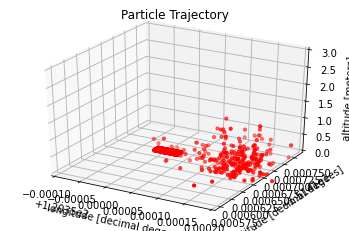

In [8]:
for i in range(0,num_particles):
    if Active[i] == 0:
        ax.scatter(Rnew[i,2],Rnew[i,1],Rnew[i,0],c='g',s=10)
        plt.figure(2,facecolor='white')
    else:
        ax.scatter(Rnew[i,2],Rnew[i,1],Rnew[i,0],c='b',s=10)
        plt.figure(2,facecolor='white')
        
fig1 = plt.figure(1,facecolor='white')
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel('longitude [decimal degees]')
ax.set_ylabel('latitude [decimal degees]')
ax.set_zlabel('altitude [meters]')
ax.set_zlim(0,height_limit)
ax.set_ylim(lat1,lat2)
ax.set_xlim(lon1,lon2)
ax.scatter(Rold[:,2],Rold[:,1],Rold[:,0],c='r',s=10)
ax.set_title('Particle Trajectory')